In [ ]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

home_dir = os.getcwd()


DATA_DIR = home_dir + '/data/example/'
METHOD_DIR = home_dir + '/method/'
MODELS_DIR = home_dir + '/method/models/models_save/'

from method.utils.utils import sample_tiles_swath, plot_tile, tile_predict_cbh, CloudBaseHeightPrediction,load_means_stds

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Example for swath file A2008.010.1245.nc

### Process swath file
Create corresponding tiles of size (128 km x 128km) of cloud properties = cloud top height, cloud optical thickness and cloud water path.
Sample the tiles randomly from the swath or with regular spacing. In the case of regular sampling, one can choose how to space the sampled tiles through the 'sampling_step' parameter ('wide' = 128 km, 'regular' = 64 km, 'fine' = 10 km, these values can be adapted in the code to suit your needs). In the case of regular sampling, the parameter 'n_tiles' is of no importance.

创建相应的云属性大小 （128 km x 128km） 的瓦片 = 云顶高度、云光学厚度和云水路径。
从条带中随机采样或以固定间距对图块进行采样。在常规采样的情况下，可以通过 'sampling_step' 参数选择如何间隔采样的图块（'wide' = 128 km，'regular' = 64 km，'fine' = 10 km，这些值可以在代码中进行调整以满足您的需要）。在常规采样的情况下，参数 'n_tiles' 并不重要。


In [3]:
swath = 'A2008.010.1245.nc'
swath_name = DATA_DIR + swath
dest_dir = DATA_DIR + 'tiles/'
regular_sampling = True
sampling_step = 'fine'
n_tiles = 20
tile_size = 128
cf_threshold = 0.3
verbose = True

In [4]:
centers = sample_tiles_swath(filename=swath_name,
                             dest_dir=dest_dir,
                             regular_sampling=regular_sampling,
                             sampling_step=sampling_step,
                             n_tiles=n_tiles,
                             tile_size=tile_size,
                             cf_threshold=cf_threshold,
                             verbose=verbose)

Swath file A2008.010.1245
    Extracting channels and cloud mask data...
    Extracting tiles for swath A2008.010.1245 ...
    11804 extracted tiles
    Saving tiles to output directory ...


#### Plot example of extracted tiles

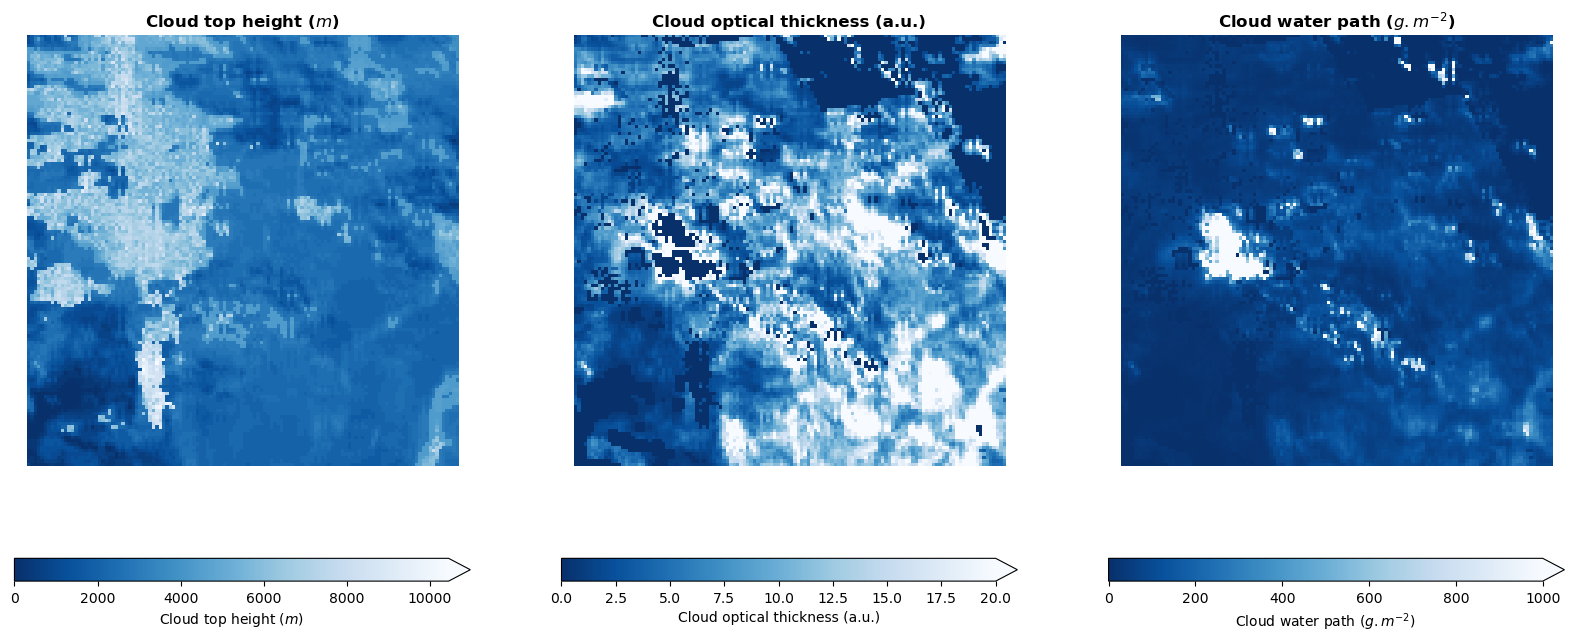

In [5]:
plot_tile(tile=dest_dir + 'A2008.010.1245_10.nc')

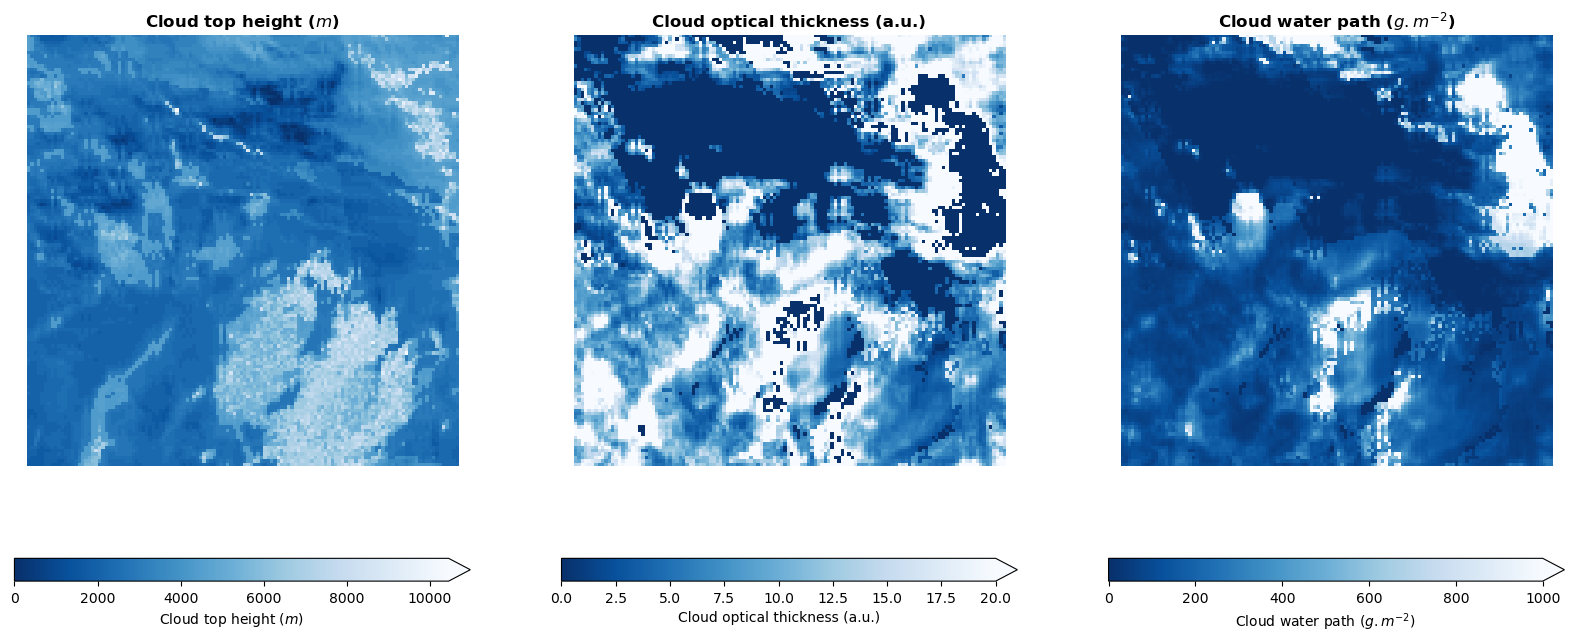

In [6]:
plot_tile(tile=dest_dir + 'A2008.010.1245_20.nc')

### Run encoding and prediction models
Load convolutional auto-encoder from file

    ae_ocean_savecheckpoint80.pt

Load ordinal regression prediction model from file

    cbh_prediction_mord_logistic_at.joblib

In [7]:
ae_model = MODELS_DIR + 'ae_ocean_savecheckpoint80.pt'
or_model = MODELS_DIR + 'cbh_prediction_mord_logistic_at.joblib'
means_stds_file = DATA_DIR + 'means_stds_save.txt' 

ddir = DATA_DIR + 'tiles/'
tile_names = 'A2008.010.1245'

In [10]:
preds, centers = tile_predict_cbh(
    ddir=ddir, tile_names=tile_names, ae_model=ae_model, or_model=or_model,
    means_stds_file=means_stds_file, verbose=True)

    Running encoding of sampled tiles...
    Predicting cloud base height...


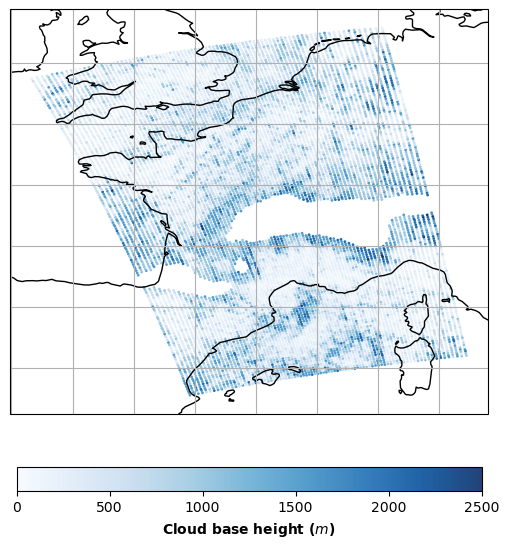

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
scat = ax.scatter(x=centers[:, 1], y=centers[:, 0],
                  s=1 if regular_sampling else 100, c=preds, vmin=0., vmax=2500.,
                  cmap='Blues', alpha=0.9)
cb = plt.colorbar(scat, orientation='horizontal', shrink=0.6, pad=0.1)
cb.set_label('Cloud base height ($m$)', weight='bold')
ax.coastlines()
ax.gridlines()
# plt.savefig('/path/to/plot/directory/method_example_notebook_plot.png',
#             dpi=300, bbox_inches='tight')

## Method wrapper function 

In [12]:
# Parameters
parameters = {
    'filename': DATA_DIR + 'A2008.010.1245.nc',
    'ddir': DATA_DIR + 'tiles/',
    'regular_sampling': False,
    'sampling_step': None,
    'n_tiles': 20,
    'tile_size': 128,
    'cf_threshold': 0.3,
    'ae_model': MODELS_DIR + 'ae_ocean_savecheckpoint80.pt',
    'or_model': MODELS_DIR + 'cbh_prediction_mord_logistic_at.joblib',
    'means_stds_file': DATA_DIR + 'means_stds_save.txt' ,
    'verbose': True
}

In [16]:
method = CloudBaseHeightPrediction(parameters)

In [17]:
preds = method.run_cbh()

Running cloud base height prediction pipeline...

-> Sampling tiles from swath files
Swath file A2008.010.1245
    Extracting channels and cloud mask data...
    Extracting tiles for swath A2008.010.1245 ...
    20 extracted tiles
    Saving tiles to output directory ...

-> Encoding sampled tiles and predicting cloud base height
    Running encoding of sampled tiles...
    Predicting cloud base height...

Done


## 测试 sample 文件夹

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 定义文件路径
input_files = ['input_1.npy', 'input_2.npy', 'input_3.npy', 'input_4.npy']
output_files = ['output_1.npy', 'output_2.npy', 'output_3.npy', 'output_4.npy']

# 加载数据
inputs = [np.load(f'data/plots_data/samples_reconstruction/{file}') for file in input_files]
outputs = [np.load(f'data/plots_data/samples_reconstruction/{file}') for file in output_files]

In [25]:
outputs[0].shape

(2, 3, 128, 128)

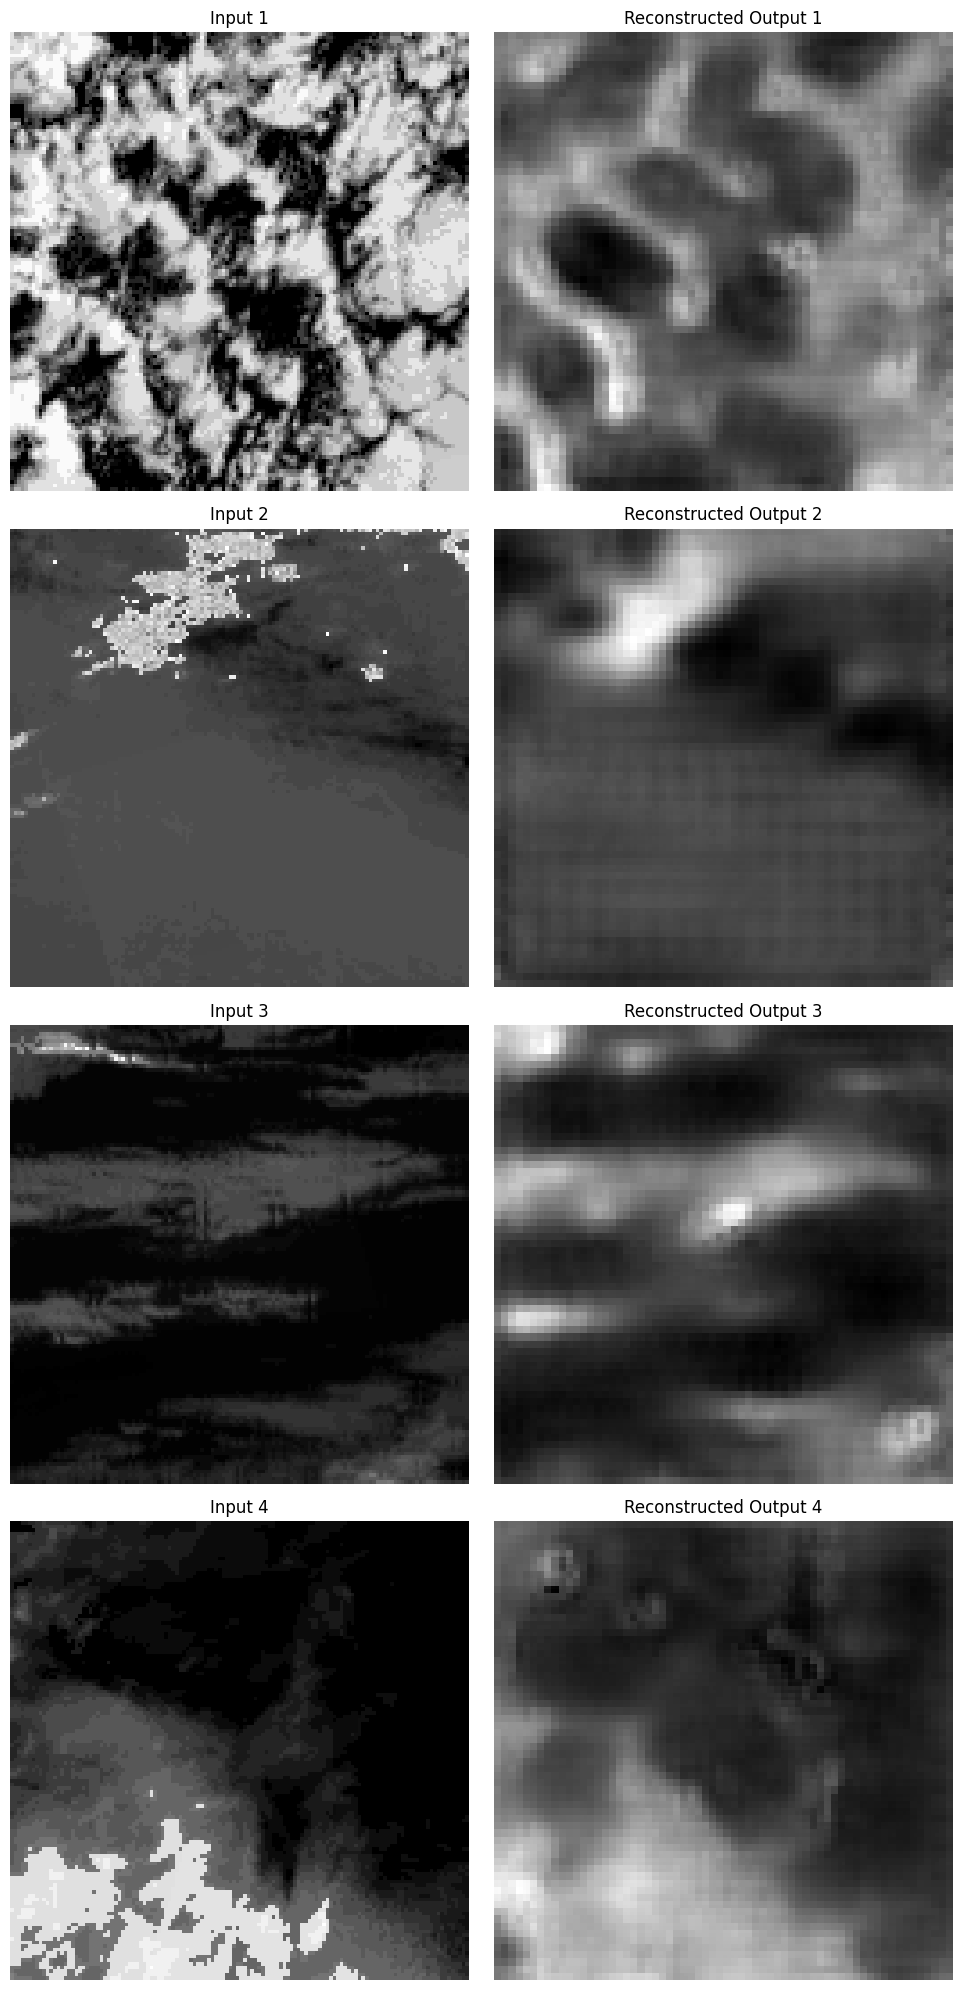

In [22]:
fig, axes = plt.subplots(nrows=len(inputs), ncols=2, figsize=(10, 20))

for i, (input_img, output_img) in enumerate(zip(inputs, outputs)):

    input_img = input_img[0, 0, :, :]  # 选择第一个瓦片的第一个通道
    output_img = output_img[0, 0, :, :]  # 选择第一个瓦片的第一个通道

    ax = axes[i, 0]
    ax.imshow(input_img.squeeze(), cmap='gray')
    ax.set_title(f'Input {i + 1}')
    ax.axis('off')

    ax = axes[i, 1]
    ax.imshow(output_img.squeeze(), cmap='gray')
    ax.set_title(f'Reconstructed Output {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error

# 计算每对输入和输出的MSE
mse_scores = [mean_squared_error(input_img.flatten(), output_img.flatten()) for input_img, output_img in zip(inputs, outputs)]

for i, mse in enumerate(mse_scores):
    print(f'MSE for Input {i + 1} and Output {i + 1}: {mse:.4f}')

MSE for Input 1 and Output 1: 0.3217
MSE for Input 2 and Output 2: 0.3874
MSE for Input 3 and Output 3: 0.1116
MSE for Input 4 and Output 4: 0.2272


## 测试 global2016文件夹

In [1]:
import pandas as pd
import xarray as xr

# 加载 CSV 文件
df = pd.read_csv('data/global_2016/df_preds_global_ae_ocean_2016.csv')

# 加载 NetCDF 文件
ds = xr.open_dataset('data/global_2016/global_counts_predictions_ae_ocean_2016.nc')

In [ ]:
# 查看基本信息
print("CSV 数据概览:")
print(df.info())


# 查看条目数量
print("\nCSV 总条目数:", len(df))


CSV 数据概览:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680880 entries, 0 to 680879
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        680880 non-null  int64  
 1   lat               680880 non-null  float64
 2   lon               680880 non-null  float64
 3   swath_name        680880 non-null  object 
 4   datetime          680880 non-null  object 
 5   month             680880 non-null  int64  
 6   day               680880 non-null  int64  
 7   pred_logistic_at  680880 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 41.6+ MB
None

CSV 总条目数: 680880


In [5]:

# 查看数据结构
print("NetCDF 文件信息:")
print(ds)

# 查看变量信息
print("\nNetCDF 变量:")
print(ds.variables)

# 查看维度
print("\nNetCDF 维度:")
print(ds.dims)

NetCDF 文件信息:
<xarray.Dataset> Size: 40MB
Dimensions:                              (lat5: 36, lon5: 72, lat1: 180,
                                          lon1: 360, cbh: 9, day: 366, month: 12)
Coordinates:
  * lat5                                 (lat5) float64 288B -87.5 ... 87.5
  * lon5                                 (lon5) float64 576B -177.5 ... 177.5
  * lat1                                 (lat1) float64 1kB -89.5 -88.5 ... 89.5
  * lon1                                 (lon1) float64 3kB -179.5 ... 179.5
  * cbh                                  (cbh) float64 72B 50.0 ... 2.5e+03
  * day                                  (day) int64 3kB 1 2 3 4 ... 364 365 366
  * month                                (month) int64 96B 1 2 3 4 ... 10 11 12
Data variables: (12/17)
    global_count_5deg                    (lat5, lon5) float64 21kB ...
    global_count_1deg                    (lat1, lon1) float64 518kB ...
    cbh_count_5deg_logistic_at           (cbh, lat5, lon5) float64 187kB ..

In [28]:
# 显示CSV文件的前几行
print(df.head())

# 显示NetCDF文件的摘要
print(ds.info())

   Unnamed: 0        lat        lon      swath_name             datetime  \
0           0 -18.937500   61.15625  A2016.273.0955  2016-09-29 09:55:00   
1           1  73.937500  149.25000  A2016.150.2350  2016-05-29 23:50:00   
2           2  18.421875 -114.31250  A2016.112.2055  2016-04-21 20:55:00   
3           3 -16.046875   42.43750  A2016.027.1030  2016-01-27 10:30:00   
4           4   6.000000  111.12500  A2016.169.0555  2016-06-17 05:55:00   

   month  day  pred_logistic_at  
0      9  273            1000.0  
1      5  150            1500.0  
2      4  112             600.0  
3      1   27             300.0  
4      6  169            1000.0  
xarray.Dataset {
dimensions:
	lat5 = 36 ;
	lon5 = 72 ;
	lat1 = 180 ;
	lon1 = 360 ;
	cbh = 9 ;
	day = 366 ;
	month = 12 ;

variables:
	float64 global_count_5deg(lat5, lon5) ;
	float64 global_count_1deg(lat1, lon1) ;
	float64 lat5(lat5) ;
	float64 lon5(lon5) ;
	float64 lat1(lat1) ;
	float64 lon1(lon1) ;
	float64 cbh(cbh) ;
	float64 cbh_cou

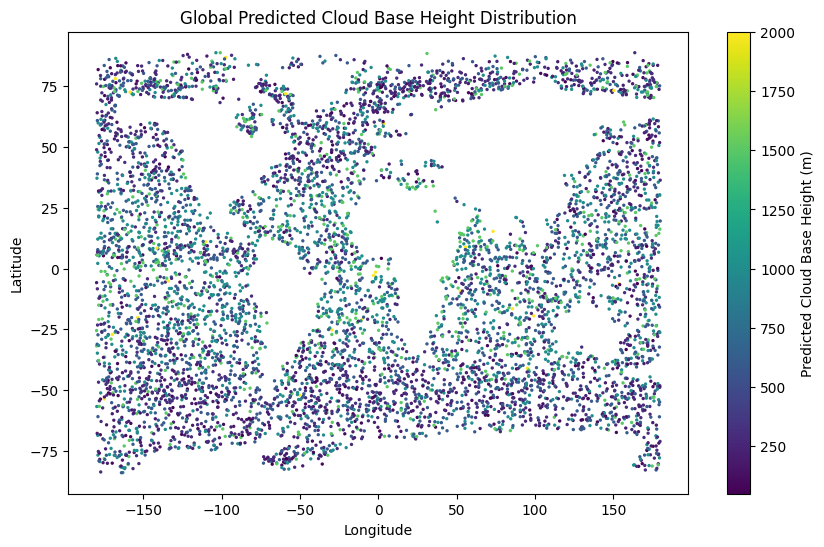

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载 CSV 数据
df = pd.read_csv('data/global_2016/df_preds_global_ae_ocean_2016.csv')

# 对数据进行抽样，例如抽取1%的数据来可视化
sample_df = df.sample(frac=0.01, random_state=1)

plt.figure(figsize=(10, 6))
plt.scatter(sample_df['lon'], sample_df['lat'],s=2 , c=sample_df['pred_logistic_at'], cmap='viridis')
plt.colorbar(label='Predicted Cloud Base Height (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Global Predicted Cloud Base Height Distribution')
plt.show()

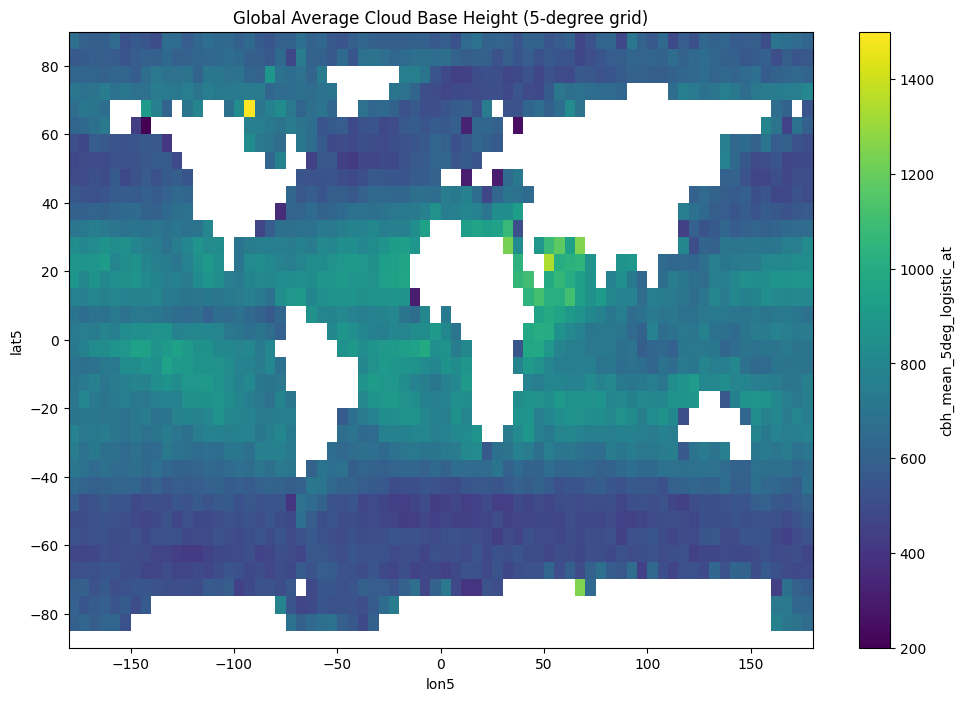

In [35]:
import xarray as xr
import matplotlib.pyplot as plt

# 加载 NetCDF 数据
ds = xr.open_dataset('data/global_2016/global_counts_predictions_ae_ocean_2016.nc')

# 可视化全球云底高度平均值（5度网格）
plt.figure(figsize=(12, 8))
ds['cbh_mean_5deg_logistic_at'].plot()
plt.title('Global Average Cloud Base Height (5-degree grid)')
plt.show()

## Appendix_A 文件夹

In [ ]:
import xarray as xr

# 加载 NetCDF 文件
ds = xr.open_dataset('data/plots_data/Appendix_A/global_occurences_synopmodis_cldbaseht.nc')

# 显示文件概览
print(ds.info())

xarray.Dataset {
dimensions:
	lat1 = 180 ;
	lon1 = 360 ;
	lat5 = 36 ;
	lon5 = 72 ;
	cbh = 9 ;

variables:
	float64 lat1(lat1) ;
	float64 lon1(lon1) ;
	float64 lat5(lat5) ;
	float64 lon5(lon5) ;
	int64 cbh(cbh) ;
	float64 cbh_count_1deg(cbh, lat1, lon1) ;
	float64 cbh_count_5deg(cbh, lat5, lon5) ;
	float64 cbh_mean_5deg(lat5, lon5) ;
	float64 cbh_std_5deg(lat5, lon5) ;
	float64 global_count_cbh_1deg(lat1, lon1) ;
	float64 global_count_cbh_5deg(lat5, lon5) ;

// global attributes:
}None


In [41]:
# 查看不同云基高度（cbh）分类下，全球1度和5度格网的计数情况
print("Cloud Base Height (CBH) Categories:", ds['cbh'].values)
print("Sample Data for 1-degree grid counts:", ds['cbh_count_1deg'].isel(cbh=0).values)
print("Sample Data for 5-degree grid counts:", ds['cbh_count_5deg'].isel(cbh=0).values)

# 统计每个格网点云基高度计数的平均值和标准差
print("Mean CBH Count at 5-degree grid:", ds['cbh_mean_5deg'].mean().values)
print("Standard Deviation of CBH Count at 5-degree grid:", ds['cbh_std_5deg'].std().values)

Cloud Base Height (CBH) Categories: [  50  100  200  300  600 1000 1500 2000 2500]
Sample Data for 1-degree grid counts: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Sample Data for 5-degree grid counts: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 1. 0.]
 ...
 [3. 0. 1. ... 0. 5. 5.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Mean CBH Count at 5-degree grid: 593.8052051273162
Standard Deviation of CBH Count at 5-degree grid: 259.06430553241825


In [47]:
# # 可视化5度格网的云基高度平均值
# fig, ax = plt.subplots(figsize=(10, 6))
# im = ds['cbh_mean_5deg'].plot(ax=ax)  # 这将返回一个mappable对象
# plt.title('Average Cloud Base Height Over 5-degree Grid')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# # plt.colorbar(im, label='Average CBH')  # 现在传入mappable对象
# plt.show()

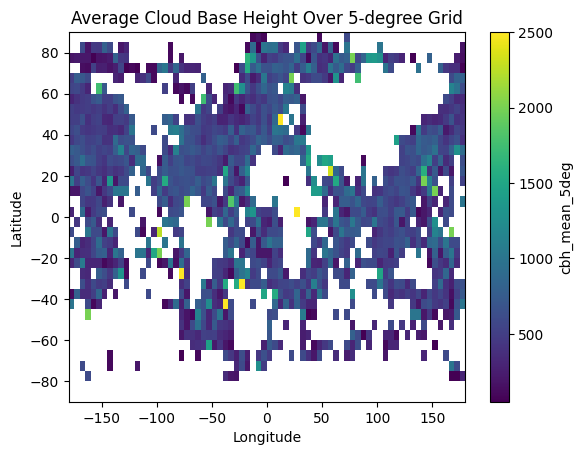

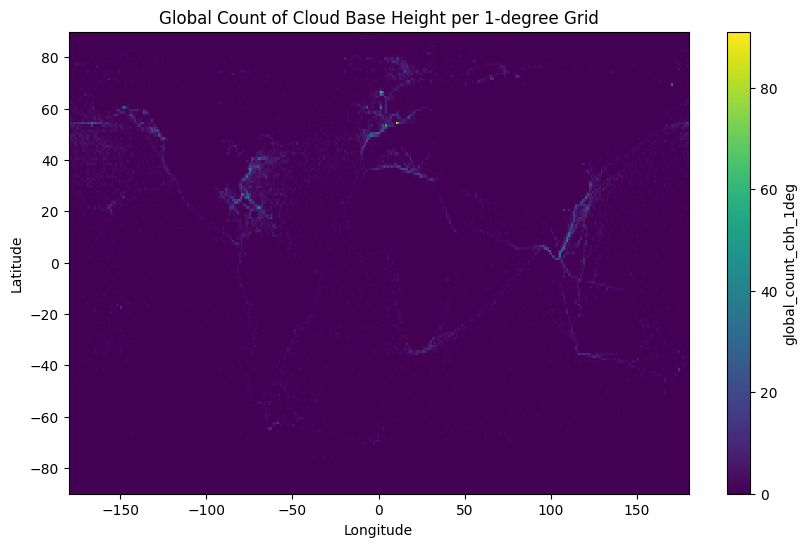

In [46]:
import matplotlib.pyplot as plt

# 可视化5度格网的云基高度平均值
ds['cbh_mean_5deg'].plot()
plt.title('Average Cloud Base Height Over 5-degree Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.colorbar(label='Average CBH')
plt.show()



# 可视化5度格网的云基高度平均值
fig, ax = plt.subplots(figsize=(10, 6))



# 可视化全球每个1度格网的云基高度计数
ds['global_count_cbh_1deg'].plot()
plt.title('Global Count of Cloud Base Height per 1-degree Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.colorbar(label='CBH Count')
plt.show()

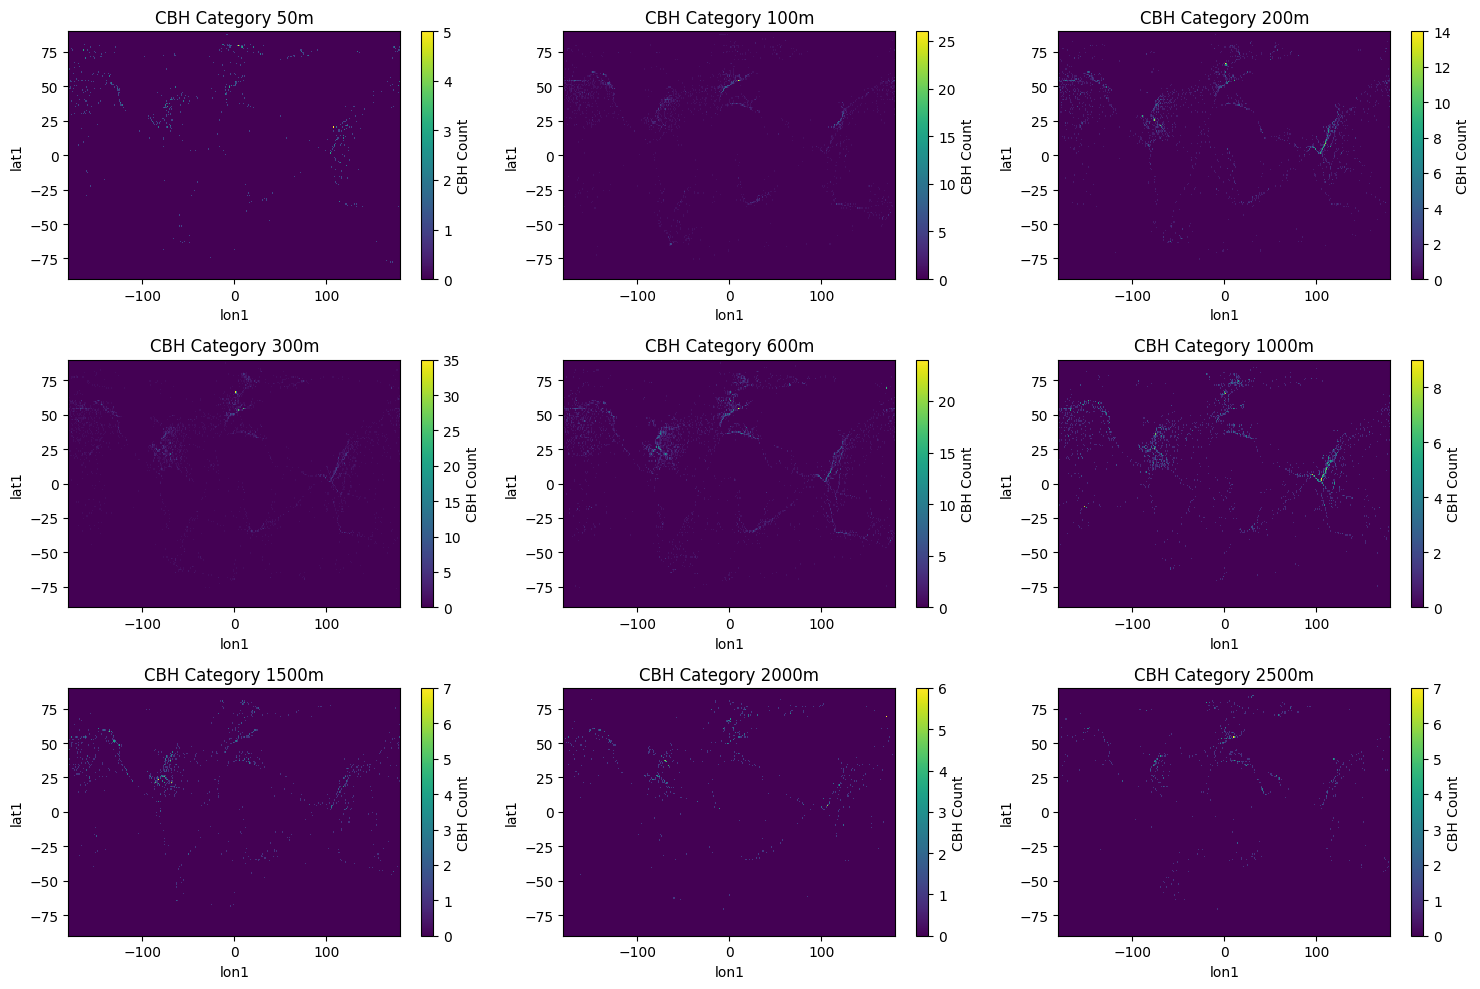

In [43]:
# 对比不同云基高度分类的全球分布情况
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    ds['cbh_count_1deg'].isel(cbh=i).plot(ax=ax, cbar_kwargs={'label': 'CBH Count'})
    ax.set_title(f'CBH Category {ds["cbh"].isel(cbh=i).values}m')
plt.tight_layout()
plt.show()

# 分析云基高度与某些气候因子（例如温度、降水量等）的相关性
# 假设已有温度和降水量数据集
# temperature = xr.open_dataset('path/to/temperature_data.nc')
# precipitation = xr.open_dataset('path/to/precipitation_data.nc')

# 计算云基高度与温度的相关性
# correlation_with_temp = xr.corr(ds['cbh_mean_5deg'], temperature['temp'], dim='time')
# correlation_with_temp.plot()
# plt.title('Correlation of CBH with Temperature')
# plt.show()

## Appendix B

In [55]:
import numpy as np
import matplotlib.pyplot as plt


channel_error_test_global_tiles_ae.npy 文件具有形状 (7111, 3)，这意味着有 7111 个样本，每个样本有三个通道的错误数据。这三个通道可能对应于不同的云属性，如云顶高度（CTH）、云光学厚度（COT）和云水路径（CWP）。

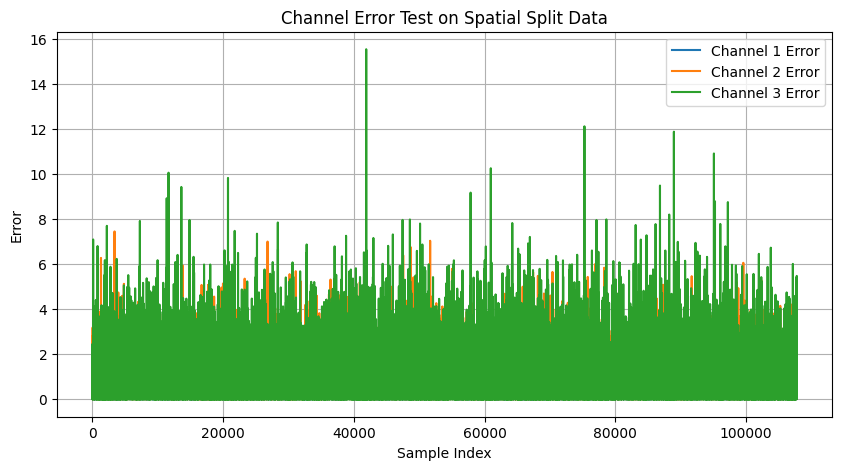

In [63]:

# 加载数据
data = np.load('data/plots_data/Appendix_B/channel_error_test_test_spatial_split_ae.npy')
data.shape

# 可视化数据
plt.figure(figsize=(10, 5))
plt.plot(data[:, 0], label='Channel 1 Error')
plt.plot(data[:, 1], label='Channel 2 Error')
plt.plot(data[:, 2], label='Channel 3 Error')
plt.title('Channel Error Test on Spatial Split Data')
plt.xlabel('Sample Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

In [72]:

# 加载数据
data = np.load('data/plots_data/Appendix_B/channel_error_test_training_dataset_test_ae.npy')
data.shape

(2099, 3)

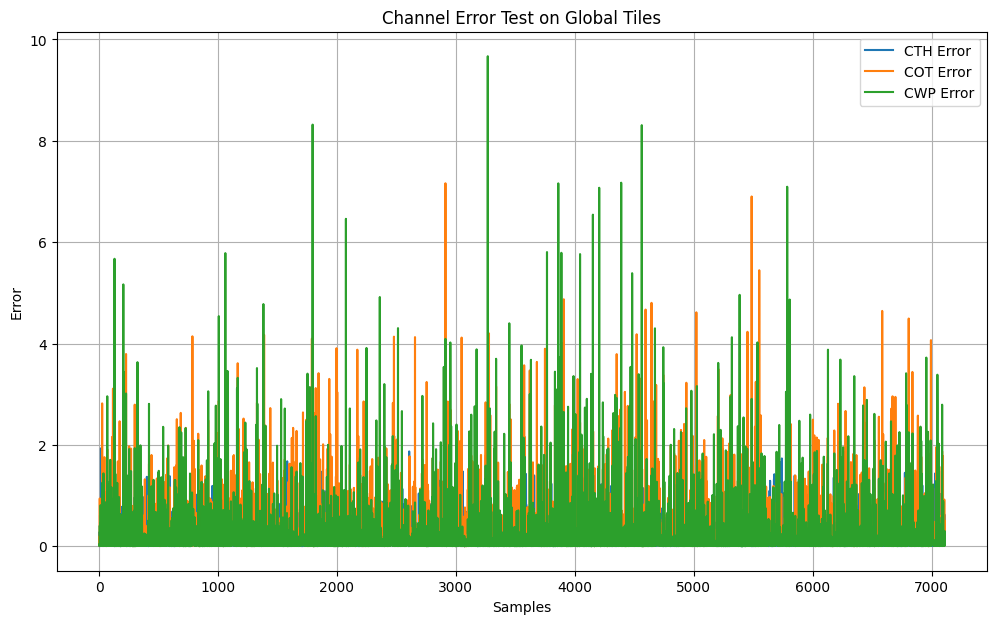

In [59]:

# 加载数据
data = np.load('data/plots_data/Appendix_B/channel_error_test_global_tiles_ae.npy')

# 可视化数据
plt.figure(figsize=(12, 7))
channels = ['CTH Error', 'COT Error', 'CWP Error']  # 假设的通道名
for i in range(data.shape[1]):
    plt.plot(data[:, i], label=channels[i])

plt.title('Channel Error Test on Global Tiles')
plt.xlabel('Samples')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

关于 .nc 文件的探索，ds.info() 命令已经给出了数据集的一些基本信息。下一步可以针对具体的数据变量进行可视化，比如可以选择可视化 global_error_mean_1deg，这代表了全球范围内每个1度网格的平均错误。

	1.	channel_error_test_global_tiles_ae.npy
	•	global_tiles_ae: 这意味着该文件包含针对全球范围内瓦片数据的自编码器模型的通道错误测试结果。
	2.	channel_error_test_test_spatial_split_ae.npy
	•	test_spatial_split_ae: 指的是空间分割的测试数据集。这表明数据可能是根据地理位置进行分割的，测试模型对于不同空间数据的表现和通道错误。
	3.	channel_error_test_test_spatio_temporal_split_ae.npy
	•	test_spatio_temporal_split_ae: 指的是同时考虑空间和时间因素分割的测试数据集。这表明该数据集既考虑了地理位置也考虑了时间序列，用于测试模型在处理同时变化的空间和时间数据上的错误。
	4.	channel_error_test_test_temporal_split_ae.npy
	•	test_temporal_split_ae: 专注于时间分割的测试数据集。这表示测试集是按时间序列分割的，用于分析模型在处理不同时间段数据的错误表现。
	5.	channel_error_test_training_dataset_test_ae.npy
	•	training_dataset_test_ae: 这可能意味着使用在训练数据集上进行的测试。尽管通常训练数据用于模型训练，但在这里可能进行了一次额外的内部测试，以评估模型在训练集上的表现。  

	1.	Channel: 在气象和遥感数据处理中，channel 常指不同的观测变量或数据通道，例如云顶高度、云光学厚度或其他气象参数。在这个项目中，channel_error 可能指的是模型对每个通道数据预测的误差或准确性分析。
	2.	Reconstruction: 在机器学习，尤其是在自编码器的应用中，reconstruction 指的是模型对输入数据进行编码后再重构（或重建）的过程。重构误差（reconstruction error）是衡量自编码器性能的一项重要指标，表明了模型在压缩并再解压数据过程中保留数据原始特征的能力。越低的重构误差表示模型在学习数据内在结构方面的表现越好。


	上述文件_error_test_…: 这些文件可能包含了针对不同测试场景（如空间分割、时空分割、时间分割和训练集测试）下，模型对每个通道数据预测的误差统计。



	1.	全局测试 (global_tiles_ae):
	•	目的：查看模型在整个世界范围内的平均表现。
	•	数据：从全球各地随机选择了7111块瓦片。
	•	方法：这种测试不关注模型在特定地区的表现，而是生成一个全球性的性能评估。
	2.	空间分割测试 (test_spatial_split_ae):
	•	目的：理解模型在特定地区的表现，特别是它对地理位置的敏感度。
	•	数据组织：107736个样本不是随机选择的，而是有意识地根据地理位置分类。比如说，可能将数据分为亚洲、欧洲、美洲的瓦片，每个大洲或地区的数据集都单独评估。
	•	测试过程：每个地区的数据独立评估，然后汇总结果看哪些地区表现好，哪些地区表现差。
	•	结果应用：通过这种分析，我们可以发现模型在某些地区可能需要更多的训练数据，或者模型在某些地区可能过度拟合了其他地区的数据。


In [78]:
import xarray as xr

# 加载NetCDF数据
ds = xr.open_dataset('data/plots_data/xarray_val_ae.nc')

# 显示数据结构
print(ds)

<xarray.Dataset> Size: 2MB
Dimensions:                 (lat5: 36, lon5: 72, lat1: 180, lon1: 360,
                             channel: 3)
Coordinates:
  * lat5                    (lat5) float64 288B -89.5 -84.5 -79.5 ... 80.5 85.5
  * lon5                    (lon5) float64 576B -179.5 -174.5 ... 170.5 175.5
  * lat1                    (lat1) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon1                    (lon1) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * channel                 (channel) <U3 36B 'cth' 'cot' 'cwp'
Data variables:
    global_count_5deg       (lat5, lon5) float64 21kB ...
    global_count_1deg       (lat1, lon1) float64 518kB ...
    global_error_mean_5deg  (lat5, lon5) float64 21kB ...
    global_error_mean_1deg  (lat1, lon1) float64 518kB ...
    global_error_std_5deg   (lat5, lon5) float64 21kB ...
    global_error_std_1deg   (lat1, lon1) float64 518kB ...
    channel_error_mean      (channel, lat5, lon5) float64 62kB ...
    channel_error_std       (channel

<xarray.Dataset> Size: 2MB
Dimensions:                 (lat5: 36, lon5: 72, lat1: 180, lon1: 360,
                             channel: 3)
Coordinates:
  * lat5                    (lat5) float64 288B -89.5 -84.5 -79.5 ... 80.5 85.5
  * lon5                    (lon5) float64 576B -179.5 -174.5 ... 170.5 175.5
  * lat1                    (lat1) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon1                    (lon1) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * channel                 (channel) <U3 36B 'cth' 'cot' 'cwp'
Data variables:
    global_count_5deg       (lat5, lon5) float64 21kB ...
    global_count_1deg       (lat1, lon1) float64 518kB ...
    global_error_mean_5deg  (lat5, lon5) float64 21kB ...
    global_error_mean_1deg  (lat1, lon1) float64 518kB ...
    global_error_std_5deg   (lat5, lon5) float64 21kB ...
    global_error_std_1deg   (lat1, lon1) float64 518kB ...
    channel_error_mean      (channel, lat5, lon5) float64 62kB ...
    channel_error_std       (channel

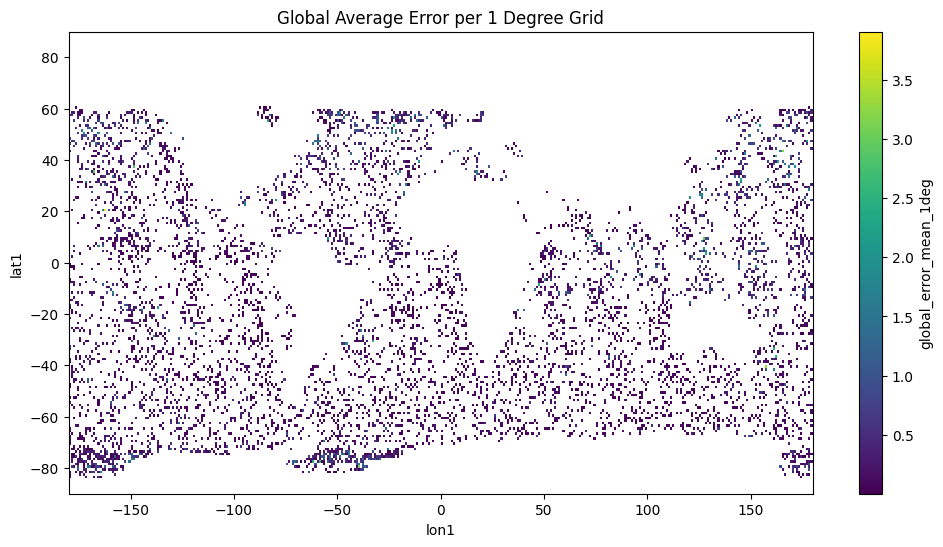

In [57]:
import xarray as xr

# 加载NetCDF数据
ds = xr.open_dataset('data/plots_data/Appendix_B/xarray_test_global_tiles_ae.nc')

# 显示数据结构
print(ds)

# 可视化全球每1度格网的平均错误
plt.figure(figsize=(12, 6))
ds['global_error_mean_1deg'].plot(cmap='viridis')
plt.title('Global Average Error per 1 Degree Grid')
# plt.colorbar(label='Error')
plt.show()

坐标系统

	•	lat1, lon1：这些是1度分辨率的全球经纬度坐标，用于描述数据点在全球范围内的精确位置。
	•	lat5, lon5：这些是5度分辨率的全球经纬度坐标，用于描述数据点在更粗略的全球网格上的位置。
	•	channel：这表示数据集中包含的不同数据通道，例如'cth' (云顶高度), 'cot' (云光学厚度), 'cwp' (云水路径)。这些通道对于云特性的遥感分析非常重要。
数据变量

	•	global_count_1deg, global_count_5deg：这些可能代表在1度和5度网格尺度上的观测计数，即在特定网格内的观测总数。
	•	global_error_mean_1deg, global_error_mean_5deg：这些表示在1度和5度网格尺度上全球平均误差，可能是模型预测和实际观测之间的平均偏差。
	•	global_error_std_1deg, global_error_std_5deg：这些表示在1度和5度网格尺度上全球误差的标准差，用于衡量预测误差的变异性。
	•	channel_error_mean, channel_error_std：这些分别表示各通道在不同网格上的平均误差和误差标准差，用于分析不同云属性预测的准确性和一致性。
	•	channel_bias_mean, channel_bias_std, channel_bias_max, channel_bias_min：这些是对各通道偏差的统计分析，包括平均偏差、偏差的标准差、最大偏差和最小偏差。这些数据帮助识别模型在不同通道上可能的系统误差。

可视化和分析

对于这些数据，可以进行多种分析和可视化，例如：

	•	制作全球地图来显示不同通道的误差和偏差分布。
	•	分析不同通道在全球不同区域的表现，看看哪些区域的预测更准确或更具挑战性。
	•	使用统计图表（如直方图、箱线图）来分析误差和偏差的分布特性。

这些分析可以帮助你了解模型在全球尺度上的表现，并指导你对模型进行改进。

## plots_data/df_preds_calipso2008.csv

该 CSV 文件包含了 2008 年的模型预测结果，与 CALIPSO 卫星观测数据 进行了比较。  
id, lat, lon, target, label, split, ridge, ridge_latlon, rf, rf_latlon, logistic_at, logistic_at_latlon, logistic_it, logistic_it_latlon, YEAR, MONTH, calipso_retrieval, calipso_cbh_labels  


- ridge, ridge_latlon, rf, rf_latlon, logistic_at, logistic_at_latlon 等，代表了使用不同模型或方法的预测结果。

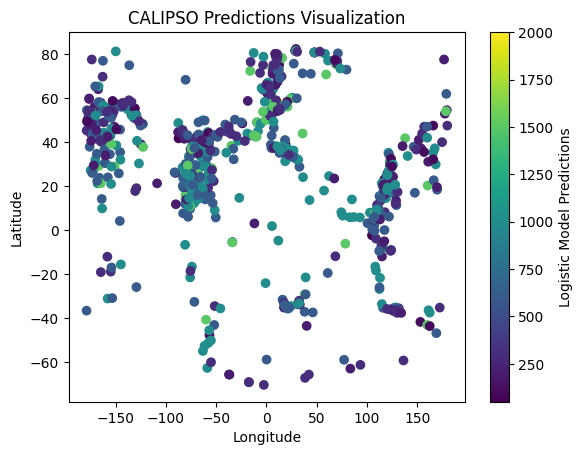

In [87]:
import pandas as pd

df = pd.read_csv('data/plots_data/df_preds_calipso2008.csv')
plt.scatter(df['lon'], df['lat'], c=df['logistic_at'], cmap='viridis')
plt.colorbar(label='Logistic Model Predictions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('CALIPSO Predictions Visualization')
plt.show()

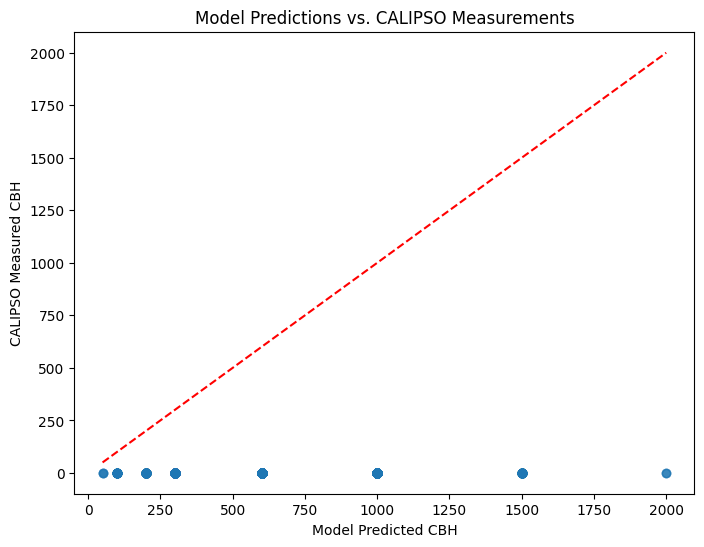

Correlation between model predictions and CALIPSO measurements:
                   logistic_at  calipso_retrieval
logistic_at                1.0                NaN
calipso_retrieval          NaN                NaN


In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# 散点图：模型预测值 vs. CALIPSO 实测值
plt.figure(figsize=(8, 6))
plt.scatter(df['logistic_at'], df['calipso_retrieval'], alpha=0.5)
plt.xlabel('Model Predicted CBH')
plt.ylabel('CALIPSO Measured CBH')
plt.title('Model Predictions vs. CALIPSO Measurements')
plt.plot([df['logistic_at'].min(), df['logistic_at'].max()], [df['logistic_at'].min(), df['logistic_at'].max()], 'r--')
plt.show()

# 计算相关系数
corr = df[['logistic_at', 'calipso_retrieval']].corr()
print('Correlation between model predictions and CALIPSO measurements:')
print(corr)

## global_occurences_observations_2008-2016.nc

	•	这是一个 NetCDF 文件，包含了 2008 至 2016 年全球云底高度观测的统计数据。
	•	数据格式：
    Dimensions: (cbh: 9, lat1: 180, lon1: 360, lat5: 36, lon5: 72)
Coordinates:
  - lat1 (lat1): -89.5, -88.5, ..., 89.5
  - lon1 (lon1): -179.5, -178.5, ..., 179.5
  - lat5 (lat5): -89.5, -84.5, ..., 85.5
  - lon5 (lon5): -179.5, -174.5, ..., 175.5
  - cbh (cbh): 50.0, 100.0, ..., 2500.0
Data variables:
  - cbh_count_1deg (cbh, lat1, lon1)
  - cbh_count_5deg (cbh, lat5, lon5)
  - cbh_mean_5deg (lat5, lon5)
  - cbh_std_5deg (lat5, lon5)
  - global_count_cbh_1deg (lat1, lon1)
  - global_count_cbh_5deg (lat5, lon5)

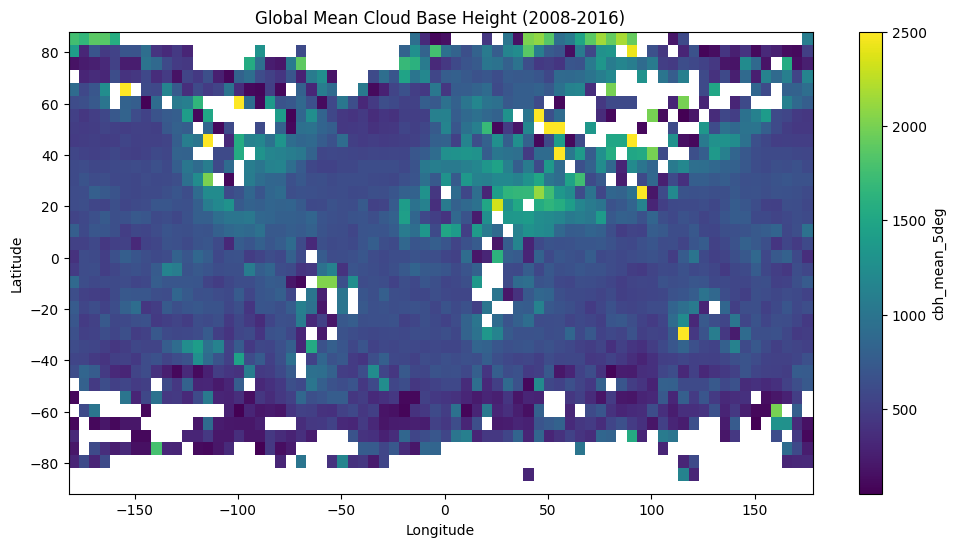

In [83]:
import xarray as xr

ds = xr.open_dataset('data/plots_data/global_occurences_observations_2008-2016.nc')

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
ds['cbh_mean_5deg'].plot(cmap='viridis')
plt.title('Global Mean Cloud Base Height (2008-2016)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

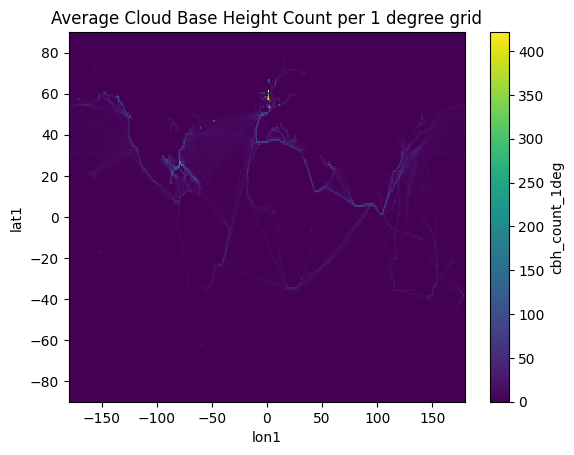

In [88]:
import xarray as xr

ds = xr.open_dataset('data/plots_data/global_occurences_observations_2008-2016.nc')
ds['cbh_count_1deg'].mean(dim='cbh').plot()
plt.title('Average Cloud Base Height Count per 1 degree grid')
plt.show()

## 3. losses_ae_ocean.csv
	•	该 CSV 文件记录了 自编码器（Autoencoder）模型在训练过程中的损失值。
	•	列头："train_loss", "train_re", "val_loss", "val_re"
    •	train_loss: 训练集总损失
	•	train_re: 训练集重构误差
	•	val_loss: 验证集总损失
	•	val_re: 验证集重构误差


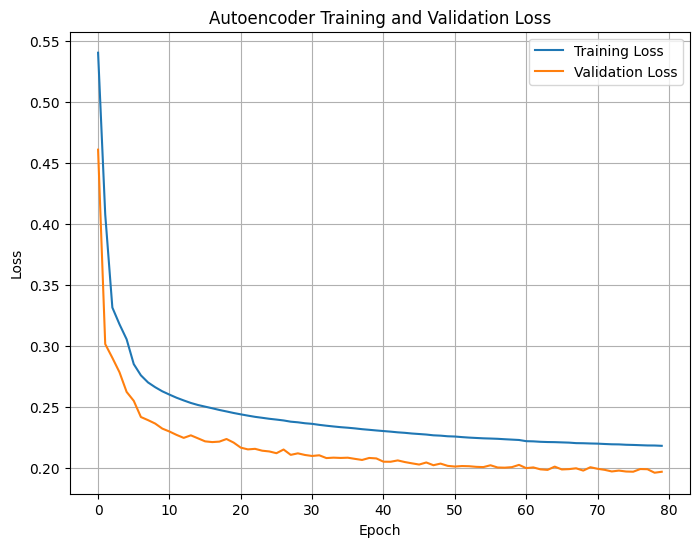

In [86]:
import pandas as pd

losses = pd.read_csv('data/plots_data/losses_ae_ocean.csv')
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(losses['train_loss'], label='Training Loss')
plt.plot(losses['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 4. synop_cbh_colocation_count.csv 和 synop_cbh_full_count.csv

内容说明：

	synop_cbh_colocation_count.csv：
	•	包含了 地面气象站（SYNOP）与卫星观测数据的配准结果。
	•	列头：id, LATITUDE, LONGITUDE, OB_TIME, YEAR, MONTH, CLD_BASE_HT
    
    synop_cbh_full_count.csv：
	•	包含了 地面气象站云底高度观测的完整统计数据。
	•	列头：id, LATITUDE, LONGITUDE, OB_TIME, CLD_BASE_HT

In [ ]:
import pandas as pd

df_colocation = pd.read_csv('path/to/plot_data/synop_cbh_colocation_count.csv')
df_full = pd.read_csv('path/to/plot_data/synop_cbh_full_count.csv')

## 5. xarray_test_2016_ae.nc, xarray_test_ae.nc, xarray_train_ae.nc

内容说明：

	•	这些 NetCDF 文件包含了 自编码器模型的训练和测试结果。
	•	数据格式
Dimensions: (lat5: 36, lon5: 72, lat1: 180, lon1: 360, channel: 3)
Coordinates:
  - lat5 (lat5): -89.5, -84.5, ..., 85.5
  - lon5 (lon5): -179.5, -174.5, ..., 175.5
  - lat1 (lat1): -89.5, -88.5, ..., 89.5
  - lon1 (lon1): -179.5, -178.5, ..., 179.5
  - channel (channel): 'cth', 'cot', 'cwp'
Data variables:
  - global_count_5deg (lat5, lon5)
  - global_count_1deg (lat1, lon1)
  - global_error_mean_5deg (lat5, lon5)
  - global_error_mean_1deg (lat1, lon1)
  - global_error_std_5deg (lat5, lon5)
  - global_error_std_1deg (lat1, lon1)
  - channel_error_mean (channel, lat5, lon5)
  - channel_error_std (channel, lat5, lon5)
  - channel_bias_mean (channel, lat5, lon5)
  - channel_bias_std (channel, lat5, lon5)
  - channel_bias_max (channel, lat5, lon5)
  - channel_bias_min (channel, lat5, lon5)


  

## test_set

cbh_preprocess_pytorch_filtered_obs_20082016_cldbaseht_test.csv

df_preds_test_reg.csv

	1.	logistic_at：
	•	可能代表：Logistic All Threshold (LogisticAT)
	•	解释：
	•	LogisticAT 是 mord 库中实现的一种序数回归方法，代表 All Threshold 方法。
	•	All Threshold (AT) 方法通过为每个类别设置单独的阈值来建模序数关系。这意味着每个类别的边界是独立学习的，有助于更灵活地捕捉数据中的复杂模式。
	2.	logistic_it：
	•	可能代表：Logistic Implicit Threshold (LogisticIT)
	•	解释：
	•	LogisticIT 也是 mord 库中实现的一种序数回归方法，代表 Implicit Threshold 方法。
	•	Implicit Threshold (IT) 方法假设阈值是隐式的，通过统一的参数设置来建模所有类别的边界。这种方法通常参数更少，训练速度更快，但可能在捕捉复杂模式时不如 All Threshold 方法灵活。

为什么会有不同的缩写？

在机器学习和神经网络中，尤其是处理序数回归问题时，不同的方法会有不同的命名以区分其建模策略。mord 库提供了多种序数回归方法，如 LogisticAT 和 LogisticIT，每种方法有其独特的优势和适用场景。

序数回归示例代码

```py
import mord
from joblib import dump

# 加载特征和标签
# X 是特征向量，y 是序数标签
# 例如：
# X = encodings
# y = y_labels

# 初始化 LogisticAT 模型
logistic_at = mord.LogisticAT()
logistic_at.fit(X, y)

# 预测
preds_at = logistic_at.predict(X)

# 保存模型
dump(logistic_at, 'logistic_at_model.joblib')

# 初始化 LogisticIT 模型
logistic_it = mord.LogisticIT()
logistic_it.fit(X, y)

# 预测
preds_it = logistic_it.predict(X)

# 保存模型
dump(logistic_it, 'logistic_it_model.joblib')
```

### 2008-2016复现
	1.	id：唯一标识符，用于区分不同的观测点或记录。
	2.	CLD_BASE_HT：云底高度（Cloud Base Height），通常以米（m）为单位，这是直接的云底观测值。
	3.	cld_mask：可能表示云的存在与否的掩码，通常用于标识观测数据中哪些是云覆盖区。
	4.	cld_base_ht_method_depth：通过某种具体方法（如声学测深）计算得到的云底高度。
	5.	cld_base_ht_mean_method_depth：基于深度方法计算的云底高度的平均值。
	6.	cld_base_ht_min_method_depth：基于深度方法计算的云底高度的最小值。
	7.	cld_base_ht_std_method_depth：基于深度方法计算的云底高度的标准差。
	8.	cld_base_ht_mean_method_depth_sub50：在某种特定情况下（如云底高度小于50米时），基于深度方法计算的云底高度的平均值。
	9.	cld_base_ht_min_method_depth_sub50：在特定条件下的云底高度最小值。
	10.	cld_base_ht_std_method_depth_sub50：在特定条件下的云底高度标准差。
	11.	cld_base_ht_method_geomth：使用几何方法计算的云底高度。
	12.	cld_base_ht_mean_method_geomth：使用几何方法计算的云底高度的平均值。
	13.	cld_base_ht_min_method_geomth：使用几何方法计算的云底高度的最小值。
	14.	cld_base_ht_std_method_geomth：使用几何方法计算的云底高度的标准差。
	15.	cld_base_ht_mean_method_geomth_sub50：特定条件下，使用几何方法的云底高度平均值。
	16.	cld_base_ht_min_method_geomth_sub50：特定条件下，使用几何方法的云底高度最小值。
	17.	cld_base_ht_std_method_geomth_sub50：特定条件下，使用几何方法的云底高度标准差。
	18.	cld_top_height_mean：云顶高度的平均值。
	19.	cld_top_height_maximum：云顶高度的最大值。
	20.	cld_top_height_minimum：云顶高度的最小值。

In [ ]:

# 提取列名
column_names = columns_df['name'].tolist()

print("列名如下：")
print(column_names)

In [ ]:
file_path = 'data/test_set/cbh_preprocess_pytorch_filtered_obs_20082016_cldbaseht_test.csv'

with open(file_path, 'r', encoding='utf-8') as f:
    first_line = f.readline()
    column_names = first_line.strip().split(',')
    print(column_names)

In [ ]:
import csv

file_path = 'data/test_set/cbh_preprocess_pytorch_filtered_obs_20082016_cldbaseht_test.csv'

try:
    with open(file_path, 'r', encoding='ascii', errors='ignore') as f:
        reader = csv.reader(f)
        column_names = next(reader)
        print(column_names)
except Exception as e:
    print(f"Error reading CSV: {e}")

In [ ]:
import pandas as pd

# 尝试不同的分隔符
try:
    df = pd.read_csv('data/test_set/cbh_preprocess_pytorch_filtered_obs_20082016_cldbaseht_test.csv', sep="\',\'", nrows=1)
    print(df)
except Exception as e:
    print("读取发生错误：", e)

/var/folders/n_/240f51110bx6m3sg1lddv4_40000gn/T/ipykernel_9463/923617828.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('data/test_set/cbh_preprocess_pytorch_filtered_obs_20082016_cldbaseht_test.csv', sep="','", nrows=1)


如果文件是 JSON 格式，或者是 CSV 文件中包含 JSON 字符串的字段，我们需要采用不同的方法读取。  
方法一：读取 JSON 文件

In [2]:
import json

file_path = 'data/test_set/cbh_preprocess_pytorch_filtered_obs_20082016_cldbaseht_test.csv'

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(type(data))
print(data.keys())

<class 'dict'>
dict_keys(['id', 'CLD_BASE_HT', 'cld_mask', 'cld_base_ht_method_depth', 'cld_base_ht_mean_method_depth', 'cld_base_ht_min_method_depth', 'cld_base_ht_std_method_depth', 'cld_base_ht_mean_method_depth_sub50', 'cld_base_ht_min_method_depth_sub50', 'cld_base_ht_std_method_depth_sub50', 'cld_base_ht_method_geomth', 'cld_base_ht_mean_method_geomth', 'cld_base_ht_min_method_geomth', 'cld_base_ht_std_method_geomth', 'cld_base_ht_mean_method_geomth_sub50', 'cld_base_ht_min_method_geomth_sub50', 'cld_base_ht_std_method_geomth_sub50', 'cld_top_height_mean', 'cld_top_height_maximum', 'cld_top_height_minimum'])


方法二：逐行读取 JSON Lines 文件

如果文件是 JSON Lines 格式（每一行是一个 JSON 对象）：

In [1]:
import json

file_path = 'data/test_set/cbh_preprocess_pytorch_filtered_obs_20082016_cldbaseht_test.csv'

with open(file_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        record = json.loads(line)
        if i == 0:
            print(record.keys())
        # 为了避免内存占用过高，可以只处理前几行
        if i > 10:
            break

dict_keys(['id', 'CLD_BASE_HT', 'cld_mask', 'cld_base_ht_method_depth', 'cld_base_ht_mean_method_depth', 'cld_base_ht_min_method_depth', 'cld_base_ht_std_method_depth', 'cld_base_ht_mean_method_depth_sub50', 'cld_base_ht_min_method_depth_sub50', 'cld_base_ht_std_method_depth_sub50', 'cld_base_ht_method_geomth', 'cld_base_ht_mean_method_geomth', 'cld_base_ht_min_method_geomth', 'cld_base_ht_std_method_geomth', 'cld_base_ht_mean_method_geomth_sub50', 'cld_base_ht_min_method_geomth_sub50', 'cld_base_ht_std_method_geomth_sub50', 'cld_top_height_mean', 'cld_top_height_maximum', 'cld_top_height_minimum'])


In [13]:
import pandas as pd
import json

file_path = '/home/jinzhi/hdd/lyj/Cloud_base_height_Method_Lenhardt2024_v2/data/test_set/df_preds_test_reg.csv'

df = pd.read_csv(file_path)

In [14]:
df.keys

<bound method NDFrame.keys of       Unnamed: 0         id   lat    lon  target  label  logistic_at  \
0              0  2073930.0   9.7  109.5   600.0    4.0        600.0   
1              1  2074078.0   5.6  119.5   600.0    4.0       1000.0   
2              2  2074088.0   1.1  119.5  2000.0    7.0       1000.0   
3              3  2074092.0  11.1  110.4   300.0    3.0       1000.0   
4              4  2074105.0  23.8  118.6  1000.0    5.0       1000.0   
...          ...        ...   ...    ...     ...    ...          ...   
2102        2102  2140272.0  46.5  153.5   200.0    2.0        100.0   
2103        2103  2140369.0 -32.0  166.9   100.0    1.0        600.0   
2104        2104  2140370.0 -34.1  170.2   300.0    3.0        300.0   
2105        2105  2140373.0 -25.1  162.5   600.0    4.0        300.0   
2106        2106  2140374.0 -40.1  177.6  2500.0    8.0       1500.0   

      logistic_it  
0          2000.0  
1          2500.0  
2          2500.0  
3          2500.0  
4    

In [2]:
df.head

<bound method NDFrame.head of                                                   id  \
0  {'18958': 2073930, '18959': 2074078, '18960': ...   

                                         CLD_BASE_HT  \
0  {'18958': 600, '18959': 600, '18960': 2000, '1...   

                                            cld_mask  \
0  {'18958': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   

                            cld_base_ht_method_depth  \
0  {'18958': [[4535.8651624015, 5409.0329653987, ...   

                       cld_base_ht_mean_method_depth  \
0  {'18958': 170.5714285714, '18959': 473.0341287...   

                        cld_base_ht_min_method_depth  \
0  {'18958': 0.0, '18959': 0.0, '18960': 0.0, '18...   

                        cld_base_ht_std_method_depth  \
0  {'18958': 136.0870069823, '18959': 404.9179645...   

                 cld_base_ht_mean_method_depth_sub50  \
0  {'18958': 200.0, '18959': 460.46869609, '18960...   

                  cld_base_ht_min_method_depth_sub50  \
0  {'18958

Pandas 读取 ， 使用 line =True

In [3]:
import pandas as pd

try:
    # 使用 pd.read_json 来读取文件，指定 chunksize 以分块读取，并设置 lines=True 处理 JSON Lines 格式
    chunks = pd.read_json('data/test_set/cbh_preprocess_pytorch_filtered_obs_20082016_cldbaseht_test.csv', lines=True, chunksize=100)
    for chunk in chunks:
        # 对每个小块进行处理
        print(chunk.head())
except Exception as e:
    print("Error:", e)

                                                  id  \
0  {'18958': 2073930, '18959': 2074078, '18960': ...   

                                         CLD_BASE_HT  \
0  {'18958': 600, '18959': 600, '18960': 2000, '1...   

                                            cld_mask  \
0  {'18958': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   

                            cld_base_ht_method_depth  \
0  {'18958': [[4535.8651624015, 5409.0329653987, ...   

                       cld_base_ht_mean_method_depth  \
0  {'18958': 170.5714285714, '18959': 473.0341287...   

                        cld_base_ht_min_method_depth  \
0  {'18958': 0.0, '18959': 0.0, '18960': 0.0, '18...   

                        cld_base_ht_std_method_depth  \
0  {'18958': 136.0870069823, '18959': 404.9179645...   

                 cld_base_ht_mean_method_depth_sub50  \
0  {'18958': 200.0, '18959': 460.46869609, '18960...   

                  cld_base_ht_min_method_depth_sub50  \
0  {'18958': 200.0, '18959': 0.0, '18960

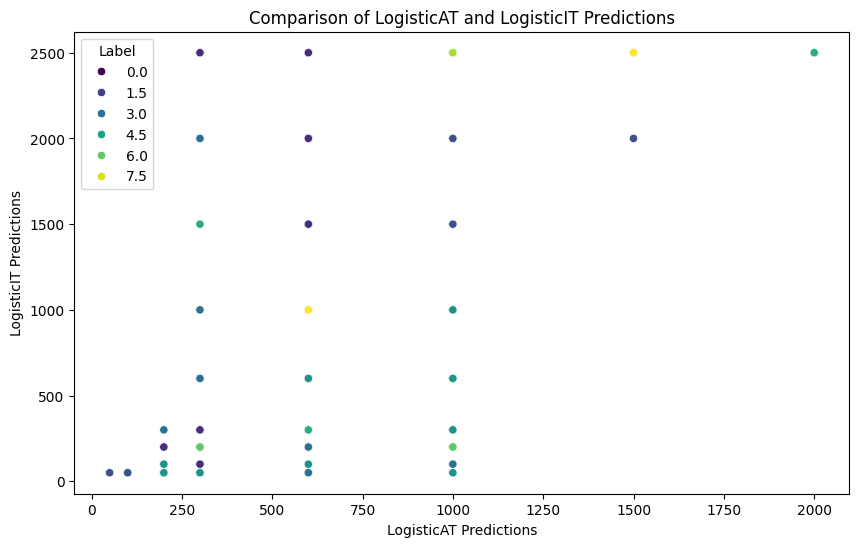

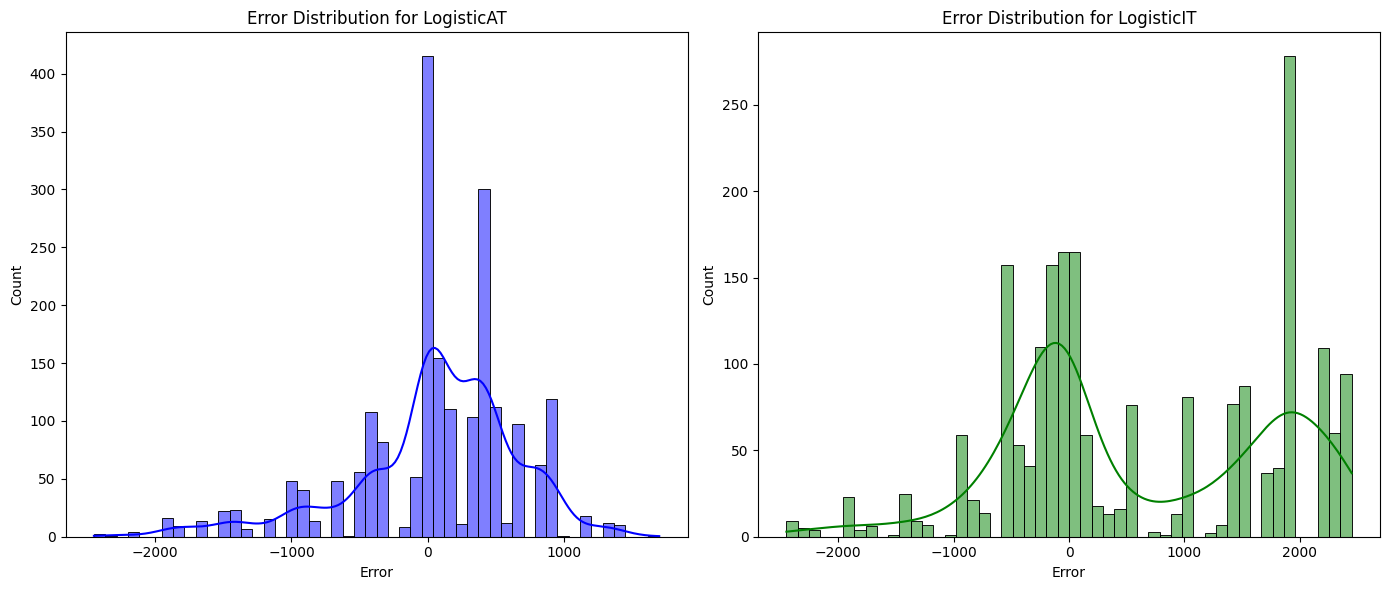

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 加载CSV文件
df = pd.read_csv('data/test_set/df_preds_test_reg.csv')

# 比较 LogisticAT 和 LogisticIT 的预测结果
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='logistic_at', y='logistic_it', hue='label', palette='viridis')
plt.xlabel('LogisticAT Predictions')
plt.ylabel('LogisticIT Predictions')
plt.title('Comparison of LogisticAT and LogisticIT Predictions')
plt.legend(title='Label')
plt.show()

# 计算并比较误差
df['error_at'] = df['logistic_at'] - df['target']
df['error_it'] = df['logistic_it'] - df['target']

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['error_at'], bins=50, kde=True, color='blue')
plt.title('Error Distribution for LogisticAT')
plt.xlabel('Error')

plt.subplot(1, 2, 2)
sns.histplot(df['error_it'], bins=50, kde=True, color='green')
plt.title('Error Distribution for LogisticIT')
plt.xlabel('Error')

plt.tight_layout()
plt.show()

In [4]:
df = pd.read_csv('data/test_set/df_preds_test_reg.csv',nrows=0)
df

,Unnamed: 0,id,lat,lon,target,label,logistic_at,logistic_it


# 训练AE 复现

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

# from method.utils.pytorch_copy import ModisGlobalTilesDataset
from method.utils.utils import sample_tiles_swath, plot_tile, tile_predict_cbh, CloudBaseHeightPrediction,load_means_stds
home_dir = os.getcwd()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from method.models.models import ConvAutoEncoder
from method.utils.pytorch_class import ModisGlobalTilesDataset



In [ ]:

data_dir = home_dir + '/data/example/tiles/'
means_stds_file = home_dir+'/data/example/means_stds_save.txt'  
model_save_dir = home_dir + '/method/models/models_save/'




learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载均值和标准差
means, stds, mins, _ = load_means_stds(means_stds_file,log_transform = False)
param_cols = ['cloud_top_height', 'cloud_optical_thickness', 'cloud_water_path']
subset = [0, 1, 2]  # 对应于上述参数的索引

In [3]:
def load_means_stds(file, log_transform=False):
    df_means_stds = pd.read_csv(file, header=0, skiprows=2, sep=' ', usecols=[0, 1, 2, 3, 4, 5])
    means = df_means_stds.iloc[0].values
    stds = df_means_stds.iloc[1].values
    mins = df_means_stds.iloc[2].values
    maxs = df_means_stds.iloc[3].values
    if log_transform:
        means_log = df_means_stds.iloc[4].values
        stds_log = df_means_stds.iloc[5].values
        means[3:5] = means_log[3:5]
        stds[3:5] = stds_log[3:5]
    return means, stds, mins, maxs

home_dir = os.getcwd()
data_dir = home_dir + '/data/example/tiles/'
means_stds_file = home_dir + '/data/example/means_stds_save.txt'
model_save_dir = home_dir + '/method/models/models_save/'


In [7]:
param_cols = ['cloud_top_height', 'cloud_optical_thickness', 'cloud_water_path']
subset = [0, 1, 2]  # Adjust index to match the data

# Initialize dataset
dataset = ModisGlobalTilesDataset(
    ddir=data_dir,
    ext='nc',
    tile='', 
    subset=subset,
    subset_cols=param_cols,
    transform=None,
    subscale=False,
    grid_size=128,
    normalize=True,
    mean=means[subset],
    std=stds[subset],
    min=mins[subset],
    log_transform=False,
    get_calipso_cbh=False
)


In [ ]:
# 调整批量大小
batch_size = 32  # 根据GPU内存调整
num_epochs = 50  #
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=32)


# 初始化模型
model = ConvAutoEncoder(n_channels=3, input_grid_size=128, latent_dim=256)
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        inputs = batch['data'].to(device, dtype=torch.float)
        optimizer.zero_grad()
        _, outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # 每10个epoch保存一次模型
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(model_save_dir, f'ae_ocean_savecheckpoint_mytrain{epoch+1}.pt')
        torch.save(model.state_dict(), checkpoint_path)

# 保存最终模型
final_model_path = os.path.join(model_save_dir, 'ae_ocean_savecheckpoint80_mytrain.pt')
torch.save(model.state_dict(), final_model_path)
print('训练完成，模型已保存至', final_model_path)


Epoch 1/50, Loss: 0.6611
Epoch 2/50, Loss: 0.5355
Epoch 3/50, Loss: 0.5098
Epoch 4/50, Loss: 0.4967
Epoch 5/50, Loss: 0.4779
Epoch 6/50, Loss: 0.4651
Epoch 7/50, Loss: 0.4549
Epoch 8/50, Loss: 0.4487
Epoch 9/50, Loss: 0.4459
Epoch 10/50, Loss: 0.4399
Epoch 11/50, Loss: 0.4359
Epoch 12/50, Loss: 0.4303
Epoch 13/50, Loss: 0.4231
Epoch 14/50, Loss: 0.4199
Epoch 15/50, Loss: 0.4185
Epoch 16/50, Loss: 0.4127
Epoch 17/50, Loss: 0.4079
Epoch 18/50, Loss: 0.4034
Epoch 19/50, Loss: 0.4007
Epoch 20/50, Loss: 0.3970
Epoch 21/50, Loss: 0.3944


In [ ]:
# 测试模型重建效果
model_name = 'ae_ocean_savecheckpoint_mytrain10.pt'
checkpoint_path = os.path.join(model_save_dir, model_name)
model = ConvAutoEncoder(n_channels=3, input_grid_size=128, latent_dim=256)
model.load_state_dict(torch.load('models_save/ae_ocean_savecheckpoint10.pt'))
model.eval()

# 获取一个样本
sample = dataset[0]
input_data = sample['data'].unsqueeze(0)  # 增加批量维度

# 前向传播
with torch.no_grad():
    _, reconstructed = model(input_data)

# 可视化输入和重建结果
import matplotlib.pyplot as plt

# 将张量转换为 NumPy 数组
input_np = input_data.numpy().squeeze()
reconstructed_np = reconstructed.numpy().squeeze()

# 绘制对比图
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
channels = ['Cloud Top Height', 'Cloud Optical Thickness', 'Cloud Water Path']

for i in range(3):
    axes[0, i].imshow(input_np[i], cmap='viridis')
    axes[0, i].set_title(f'Input {channels[i]}')
    axes[1, i].imshow(reconstructed_np[i], cmap='viridis')
    axes[1, i].set_title(f'Reconstructed {channels[i]}')

plt.tight_layout()
plt.show()

# 测试cumulo数据集

In [21]:
import netCDF4 as nc4
from netCDF4 import Dataset
import numpy as np
import numpy as np
import netCDF4 as nc4
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [48]:
cumulo_path = '/home/jinzhi/hdd/lyj/CUMULO_data/A2008.001.0505.nc'
fill_value = nc4.Dataset(cumulo_path, 'r', format='NETCDF4').variables['cloud_layer_base']._FillValue


In [49]:
dataset = nc.Dataset(cumulo_path)
# 读取cloud_mask数据
cloud_mask = dataset.variables['cloud_mask'][:]

# 查看cloud_mask的基本信息
print(cloud_mask)

# 假设1代表有云，0代表无云
cloudy_pixels = np.sum(cloud_mask == 1)
total_pixels = cloud_mask.size
cloudy_percentage = (cloudy_pixels / total_pixels) * 100

print(f"Total pixels: {total_pixels}")
print(f"Cloudy pixels: {cloudy_pixels}")
print(f"Percentage of cloudy pixels: {cloudy_percentage:.2f}%")


[[[-- 1 1 ... 1 1 1]
  [-- 1 1 ... -- 1 1]
  [1 1 1 ... -- 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]]
Total pixels: 2748620
Cloudy pixels: 2257691
Percentage of cloudy pixels: 82.14%


In [50]:
def read_cloud_layer_base(nc_file):
    """Return masked arrays, with custom masks for invalid and non-cloud values."""
    file = nc4.Dataset(nc_file, 'r', format='NETCDF4')
    
    # Assuming cloud_layer_base is the only property we're interested in
    cloud_layer_base = file.variables['cloud_layer_base'][:]
    fill_value = file.variables['cloud_layer_base']._FillValue
    cloud_mask = file.variables['cloud_mask'][:]
        
        # 广播

    cloud_mask = np.expand_dims(cloud_mask, axis=-1)  # Expand dimensions at the end
    cloud_mask = np.repeat(cloud_mask, cloud_layer_base.shape[-1], axis=-1)  # Repeat across the new last dimension

    
    # Apply mask for fill value and combine with cloud mask
    valid_mask = (cloud_layer_base != fill_value) & (cloud_mask == 1)

    # Mask the cloud_layer_base data
    masked_cloud_layer_base = np.ma.array(cloud_layer_base, mask=~valid_mask)
    
    return masked_cloud_layer_base

# Example usage
# cumulo_path = "path_to_your_nc_file.nc"
masked_cloud_layer_base = read_cloud_layer_base(cumulo_path)

# Verify the shape and type
print("Shape:", masked_cloud_layer_base.shape)
print("Type:", type(masked_cloud_layer_base))

Shape: (1, 1354, 2030, 10)
Type: <class 'numpy.ma.core.MaskedArray'>


MemoryError: Unable to allocate 27.5 TiB for an array with shape (2748620, 2748620) and data type float32

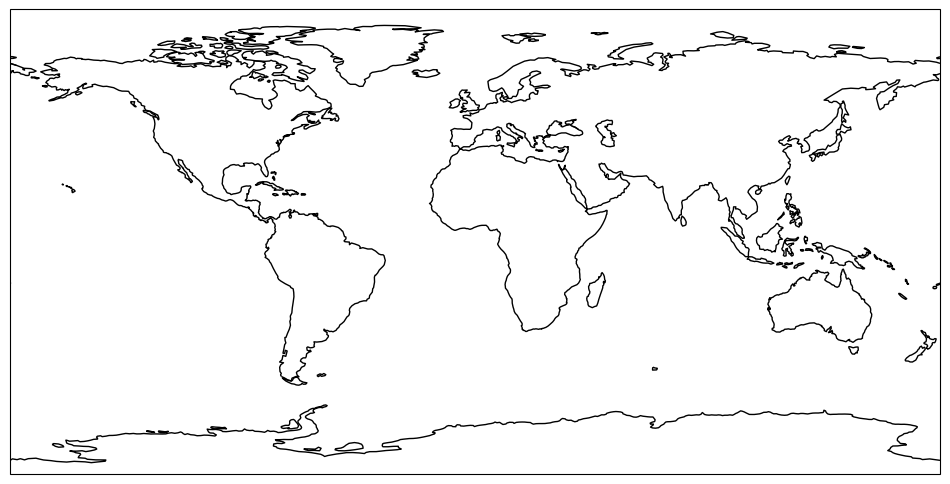

In [51]:
def plot_data(lat, lon, data):
    """Plot masked cloud layer base data on a map."""
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()
    ax.set_global()
    
    if lat.ndim > 2 and isinstance(lon, np.ma.MaskedArray):
        lat = lat[0, :, :].compressed()  
    if lon.ndim > 2 and isinstance(lon, np.ma.MaskedArray):
        lon = lon[0, :, :].compressed()  
    

    lon2d, lat2d = np.meshgrid(lon, lat)  # Ensure lon and lat are meshed if they're 1D

    # Assume the data is 2D and corresponds to the first time slice and first layer
    data_slice = data[0, :, :, 0]  # Adjust slicing if needed
    mesh = ax.pcolormesh(lon2d, lat2d, data_slice, cmap='viridis', transform=ccrs.PlateCarree())

    plt.colorbar(mesh, ax=ax, shrink=0.5, label='Cloud Layer Base (km)')
    plt.title('Cloud Layer Base Heights')
    plt.show()

# Load latitude and longitude data
latitude = nc4.Dataset(cumulo_path).variables['latitude'][:]
longitude = nc4.Dataset(cumulo_path).variables['longitude'][:]
# latitude.shape
# longitude.compressed()
# Call the plot function with the masked data
plot_data(latitude, longitude, masked_cloud_layer_base)

MemoryError: Unable to allocate 27.5 TiB for an array with shape (2748620, 2748620) and data type float32

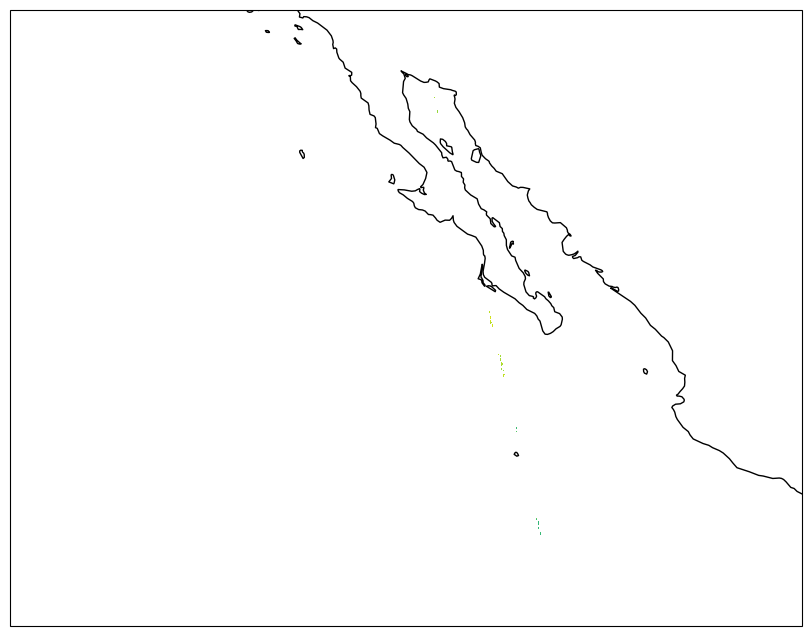

In [30]:
import netCDF4 as nc
import numpy as np

# 打开 netCDF 文件
nc_file = nc.Dataset('/home/jinzhi/hdd/lyj/CUMULO_data/A2016.112.2055.nc', 'r')

# 提取变量
cloud_layer_base = nc_file.variables['cloud_layer_base'][:]
latitude = nc_file.variables['latitude'][:]
longitude = nc_file.variables['longitude'][:]


# 获取填充值
cloud_fill_value = nc_file.variables['cloud_layer_base']._FillValue
lat_fill_value = nc_file.variables['latitude']._FillValue
lon_fill_value = nc_file.variables['longitude']._FillValue

# 创建掩码数组
cloud_layer_base = np.ma.masked_where(cloud_layer_base == cloud_fill_value, cloud_layer_base)
latitude = np.ma.masked_where(latitude == lat_fill_value, latitude)
longitude = np.ma.masked_where(longitude == lon_fill_value, longitude)

# 选择第一个时间步和第一层
cloud_base = cloud_layer_base[0, :, :, 0]

# 移除时间维度
lat = latitude[0, :, :]
lon = longitude[0, :, :]
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 创建带投影的图形和轴
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# 添加海岸线
ax.coastlines()

# 绘制云底高度
cf = ax.pcolormesh(lon, lat, cloud_base, cmap='viridis', transform=ccrs.PlateCarree())

lon2d, lat2d = np.meshgrid(lon, lat)  # 确保经纬度是二维的

# 绘制云底高度，改用散点图
scatter = ax.scatter(lon.compressed(), lat.compressed(), c=cloud_base.compressed(), s=10, cmap='viridis', transform=ccrs.PlateCarree(), alpha=0.5)
                    
# 添加颜色条
cbar = plt.colorbar(cf, ax=ax, shrink=0.5)
cbar.set_label('云层底部高度 (km)')

# 设置标题
plt.title('云层底部高度')

# 显示图形
plt.show()

# 在每个位置取最小的云底高度
cloud_base_min = np.ma.min(cloud_layer_base[0, :, :, :], axis=2)

# 使用 'cloud_base_min' 进行绘图
cf = ax.pcolormesh(lon, lat, cloud_base_min, cmap='viridis', transform=ccrs.PlateCarree())

In [60]:
# 检查掩码数组中有效数据的数量
print("Total data points:", cloud_base.size)
print("Masked data points:", np.ma.count_masked(cloud_base))
print("Unmasked (valid) data points:", cloud_base.count())

Total data points: 2748620
Masked data points: 2747181
Unmasked (valid) data points: 1439


### 处理多个层

In [ ]:
# 在每个位置取最小的云底高度
cloud_base_min = np.ma.min(cloud_layer_base[0, :, :, :], axis=2)

# 使用 'cloud_base_min' 进行绘图
cf = ax.pcolormesh(lon, lat, cloud_base_min, cmap='viridis', transform=ccrs.PlateCarree())

In [ ]:


radiances = ['ev_250_aggr1km_refsb_1', 'ev_250_aggr1km_refsb_2', 'ev_1km_emissive_29', 'ev_1km_emissive_33', 'ev_1km_emissive_34', 'ev_1km_emissive_35', 'ev_1km_emissive_36', 'ev_1km_refsb_26', 'ev_1km_emissive_27', 'ev_1km_emissive_20', 'ev_1km_emissive_21', 'ev_1km_emissive_22', 'ev_1km_emissive_23']
# radiances = []
coordinates = ['latitude', 'longitude']
# properties = ['cloud_water_path', 'cloud_optical_thickness', 'cloud_effective_radius', 'cloud_phase_optical_properties', 'cloud_top_pressure', 'cloud_top_height', 'cloud_top_temperature', 'cloud_emissivity', 'surface_temperature']
properties = ['cloud_layer_base']
rois = 'cloud_mask'
labels = 'cloud_layer_type'

def read_nc(nc_file):
    """return masked arrays, with masks indicating the invalid values"""
    
    file = nc4.Dataset(nc_file, 'r', format='NETCDF4')

    f_radiances = np.vstack([file.variables[name][:] for name in radiances])
    f_properties = np.vstack([file.variables[name][:] for name in properties])
    f_rois = file.variables[rois][:]
    f_labels = file.variables[labels][:]

    return f_radiances, f_properties, f_rois, f_labels

f_radiances, f_properties, f_rois, f_labels = read_nc(cumulo_path)

In [182]:
cloud_layer_base = f_properties[0]
print(type(cloud_layer_base))
mask = cloud_layer_base.mask
type(mask)
valid_cloud_layer_base = cloud_layer_base[~mask]

<class 'numpy.ma.core.MaskedArray'>


In [183]:
print(valid_cloud_layer_base.compressed())

[-99. -99. -99. ... -99. -99. -99.]


In [177]:
# 检查形状和数据
print("Shape of valid cloud_layer_base data:", valid_cloud_layer_base.shape)
print("Sample of valid data:", valid_cloud_layer_base[:10])  # 展示一些有效的样本数据

Shape of valid cloud_layer_base data: (1, 1354, 2030, 10)
Sample of valid data: [[[[-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ... -99. -99. -99.]
   ...
   [-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ... -99. -99. -99.]]

  [[-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ... -99. -99. -99.]
   ...
   [-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ... -99. -99. -99.]]

  [[-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ... -99. -99. -99.]
   ...
   [-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ... -99. -99. -99.]]

  ...

  [[-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ... -99. -99. -99.]
   ...
   [-99. -99. -99. ... -99. -99. -99.]
   [-99. -99. -99. ..

In [172]:
sum(sum(f_properties[0]))

masked_array(data=[-2.7211693e+08, -2.7211693e+08, -2.7211693e+08,
                   -2.7211693e+08, -2.7211693e+08, -2.7211693e+08,
                   -2.7211693e+08, -2.7211693e+08, -2.7211693e+08,
                   -2.7211693e+08],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

### 提取对应的其他变量

In [21]:
import netCDF4 as nc
import numpy as np

# 打开 netCDF 文件
nc_file = nc.Dataset('/home/jinzhi/hdd/lyj/CUMULO_data/A2016.112.2055.nc', 'r')

# 提取变量
cloud_layer_base = nc_file.variables['cloud_layer_base'][:]
latitude = nc_file.variables['latitude'][:]
longitude = nc_file.variables['longitude'][:]


# 获取填充值
cloud_fill_value = nc_file.variables['cloud_layer_base']._FillValue
lat_fill_value = nc_file.variables['latitude']._FillValue
lon_fill_value = nc_file.variables['longitude']._FillValue

# 掩盖无效数据
cloud_layer_base = np.ma.masked_where(cloud_layer_base == cloud_fill_value, cloud_layer_base)
latitude = np.ma.masked_where(latitude == lat_fill_value, latitude)
longitude = np.ma.masked_where(longitude == lon_fill_value, longitude)

# # 选择第一个时间步和第一层
# cloud_base = cloud_layer_base[0, :, :, 0]

# cloud_base.shape


# 选择时间维度（假设时间维度为 0）
time_index = 0

# 对于每个层，提取有效数据点
valid_mask = ~cloud_layer_base[time_index].mask


In [24]:
valid_mask.shape

(1354, 2030, 10)

In [ ]:

# 移除时间维度
lat = latitude[0, :, :]
lon = longitude[0, :, :]
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 创建带投影的图形和轴
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# 添加海岸线
ax.coastlines()

# 绘制云底高度
cf = ax.pcolormesh(lon, lat, cloud_base, cmap='viridis', transform=ccrs.PlateCarree())

# 添加颜色条
cbar = plt.colorbar(cf, ax=ax, shrink=0.5)
cbar.set_label('云层底部高度 (km)')

# 设置标题
plt.title('云层底部高度')

# 显示图形
plt.show()

# 在每个位置取最小的云底高度
cloud_base_min = np.ma.min(cloud_layer_base[0, :, :, :], axis=2)

# 使用 'cloud_base_min' 进行绘图
cf = ax.pcolormesh(lon, lat, cloud_base_min, cmap='viridis', transform=ccrs.PlateCarree())

# 下载数据

可能先根据df构建文件路径，然后使用rclone下载

如果知道文件的具体路径，推荐直接使用 rclone copy。

files_to_download = ['A2016.273.0955.nc', 'A2016.150.2350.nc', 'A2016.112.2055.nc']


- rclone copy remote_name:/2016/09/273/daylight/A2016.273.0955.nc /local/path/to/save
- rclone copy remote_name:/2016/05/150/daylight/A2016.150.2350.nc /local/path/to/save
- rclone copy remote_name:/2016/04/112/daylight/A2016.112.2055.nc /local/path/to/save

在远程服务器上（或云存储中）将需要的文件压缩成 .zip 或 .tar.gz 文件：

In [19]:

# 加载 CSV 文件
df = pd.read_csv('data/global_2016/df_preds_global_ae_ocean_2016.csv')
# 计算 unique 的 swath_name 数量
unique_swath_names = df['swath_name'].unique()[:3]

print(f"Unique swath_name 数量: {unique_swath_names}")

Unique swath_name 数量: ['A2016.273.0955' 'A2016.150.2350' 'A2016.112.2055']


In [ ]:
import os
import requests
from tqdm import tqdm

# 需要下载的文件列表
file_list =  unique_swath_names


save_dir = "/Users/liyujia/Downloads"


# 下载函数
def download_nc_files(file_list, save_dir):
    for file_name in tqdm(file_list, desc="Downloading NetCDF files"):
        # 提取年份和儒略日（day of year）
        year = file_name[1:5]
        day_of_year = file_name[6:9]
        
        # 将 day_of_year 转换为月份和日期
        date = datetime.strptime(f"{year} {day_of_year}", "%Y %j")
        month = date.strftime("%m")
        day = date.strftime("%d")
        
        # 构建文件的下载链接
        # 假设文件存储在以下结构中：
        # https://www.dropbox.com/.../{year}/{month}/{day_of_year}/daylight/{file_name}.nc?dl=1
        base_url = f"https://www.dropbox.com/scl/fo/o2d8glykv1jga5uj5mlk0/AAn-FqRHe9vqYjrwyldxNC8/{year}/{month}/{day_of_year}/daylight/"
        file_url = f"{base_url}{file_name}.nc?dl=1"
        
        save_path = os.path.join(save_dir, f"{file_name}.nc")
        
        # 如果文件已存在，则跳过
        if os.path.exists(save_path):
            print(f"{file_name}.nc 已存在，跳过...")
            continue
        
        # 下载文件
        try:
            response = requests.get(file_url, stream=True)
            response.raise_for_status()  # 检查 HTTP 请求是否成功

            # 保存文件
            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):  # 分块下载
                    f.write(chunk)
            print(f"{file_name}.nc 下载完成！")
        
        except requests.exceptions.RequestException as e:
            print(f"下载 {file_name}.nc 时出错：{e}")

# 执行下载
download_nc_files(file_list, save_dir)